In [18]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout, RandomFlip, RandomRotation, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session

In [19]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [20]:
### PLOTTING 10 SAMPLES FROM EACH CLASS ###
""" # Create a 10x10 subplot grid
fig, axs = plt.subplots(10, 10, figsize=(6, 6))

# Iterate over each class
for i, c in enumerate(np.unique(y_train)):
    # Select 10 random samples from this class
    idx = np.random.choice(np.where(y_train == c)[0], 10, replace=False)
    
    # Iterate over the 10 random samples
    for j, idx_j in enumerate(idx):
        # Get the corresponding image
        img = x_train[idx_j]
        
        # Display the image in the subplot
        axs[j, i].imshow(img)
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])

# Layout so plots do not overlap
fig.tight_layout()
plt.show() """

' # Create a 10x10 subplot grid\nfig, axs = plt.subplots(10, 10, figsize=(6, 6))\n\n# Iterate over each class\nfor i, c in enumerate(np.unique(y_train)):\n    # Select 10 random samples from this class\n    idx = np.random.choice(np.where(y_train == c)[0], 10, replace=False)\n    \n    # Iterate over the 10 random samples\n    for j, idx_j in enumerate(idx):\n        # Get the corresponding image\n        img = x_train[idx_j]\n        \n        # Display the image in the subplot\n        axs[j, i].imshow(img)\n        axs[j, i].set_xticks([])\n        axs[j, i].set_yticks([])\n\n# Layout so plots do not overlap\nfig.tight_layout()\nplt.show() '

In [21]:
# Normalizing the images
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [22]:
# Convert the labels from numerical to categorical (one-hot encoded)
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(y_train.shape)
print(y_test.shape)

(50000, 10)
(10000, 10)


In [23]:
""" # Data Augmentation
data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2)])

# Create a tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)

# Visualize augmented images
for images, _ in train_dataset.take(1):
    plt.figure(figsize=(4, 4))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0])
        plt.axis('off')
    plt.show()
 """

" # Data Augmentation\ndata_augmentation = Sequential([\n    RandomFlip('horizontal'),\n    RandomRotation(0.2)])\n\n# Create a tf.data.Dataset\ntrain_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)\n\n# Visualize augmented images\nfor images, _ in train_dataset.take(1):\n    plt.figure(figsize=(4, 4))\n    first_image = images[0]\n    for i in range(9):\n        ax = plt.subplot(3, 3, i + 1)\n        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))\n        plt.imshow(augmented_image[0])\n        plt.axis('off')\n    plt.show()\n "

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Enhanced Data Augmentation with more variations
datagen = ImageDataGenerator(
    rotation_range=30,          # Increase rotation
    width_shift_range=0.3,      # Increase horizontal shift
    height_shift_range=0.3,     # Increase vertical shift
    horizontal_flip=True,       # Allow flips
    zoom_range=0.2,             # Add zooming
    brightness_range=[0.7, 1.3], # Increase brightness adjustment range
    shear_range=0.2             # Add shear transformations
)
# Apply the augmentation
datagen.fit(x_train)  # Ensure x_train is used with augmented batches during training

In [25]:
### SEQUENTIAL MODEL ###
# TODO: Learning rate Scheduler
# TODO: Kernel Regularizer
clear_session()

# Defining the model
model_seq = Sequential()
model_seq.add(Input(shape=(32, 32, 3)))

# 1st Convolutional Block
model_seq.add(Conv2D(64, (3, 3), padding='same'))
model_seq.add(BatchNormalization())
model_seq.add(Activation("relu"))
model_seq.add(Conv2D(64, (3, 3), padding='same'))
model_seq.add(BatchNormalization())
model_seq.add(Activation("relu"))
model_seq.add(MaxPooling2D((2, 2)))
model_seq.add(Dropout(0.2))

# 2nd Convolutional Block
model_seq.add(Conv2D(128, (3, 3), padding='same'))
model_seq.add(BatchNormalization())
model_seq.add(Activation("relu"))
model_seq.add(Conv2D(128, (3, 3), padding='same'))
model_seq.add(BatchNormalization())
model_seq.add(Activation("relu"))
model_seq.add(MaxPooling2D((2, 2)))
model_seq.add(Dropout(0.2))

# 3nd Convolutional Block
model_seq.add(Conv2D(256, (3, 3), padding='same'))
model_seq.add(BatchNormalization())
model_seq.add(Activation("relu"))
model_seq.add(Conv2D(256, (3, 3), padding='same'))
model_seq.add(BatchNormalization())
model_seq.add(Activation("relu"))
model_seq.add(MaxPooling2D((2, 2)))
model_seq.add(Dropout(0.6))

# Dense Layers
model_seq.add(Flatten())
model_seq.add(Dense(128))
model_seq.add(BatchNormalization())
model_seq.add(Activation("relu"))
model_seq.add(Dropout(0.6))

# Output Layer
model_seq.add(Dense(10))
model_seq.add(BatchNormalization())
model_seq.add(Activation("softmax"))

#model_seq.summary()

# Define Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)

do_train_seq = True
if do_train_seq:
    # Compiling the model # TODO: Try different accuracy metrics?
    model_seq.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Training the model
    history = model_seq.fit(x_train, y_train,
        epochs=50, #50
        batch_size=256, #512
        validation_split=0.2,
        #validation_steps=int(0.2 * x_test.shape[0] / 512), # Fixed because we're generating val data automatically with validation_split
        callbacks=[early_stopping]
        )

Epoch 1/50


2024-09-25 15:42:53.464804: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


157/157 [==============================] - 10s 29ms/step - loss: 1.6976 - accuracy: 0.4026 - val_loss: 2.8629 - val_accuracy: 0.0952
Epoch 2/50
157/157 [==============================] - 4s 25ms/step - loss: 1.3039 - accuracy: 0.5773 - val_loss: 2.9169 - val_accuracy: 0.1156
Epoch 3/50
157/157 [==============================] - 4s 25ms/step - loss: 1.0932 - accuracy: 0.6582 - val_loss: 1.3525 - val_accuracy: 0.5493
Epoch 4/50
157/157 [==============================] - 4s 25ms/step - loss: 0.9596 - accuracy: 0.7046 - val_loss: 0.9650 - val_accuracy: 0.6981
Epoch 5/50
157/157 [==============================] - 4s 25ms/step - loss: 0.8619 - accuracy: 0.7363 - val_loss: 1.1304 - val_accuracy: 0.6210
Epoch 6/50
157/157 [==============================] - 4s 25ms/step - loss: 0.7695 - accuracy: 0.7679 - val_loss: 0.8022 - val_accuracy: 0.7363
Epoch 7/50
157/157 [==============================] - 4s 25ms/step - loss: 0.7117 - accuracy: 0.7840 - val_loss: 0.8349 - val_accuracy: 0.7258
Epoch 8/5

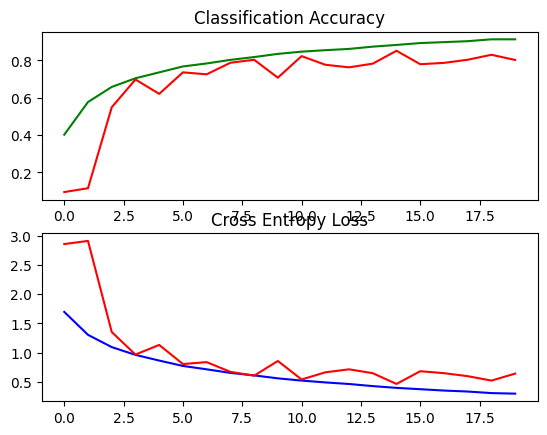

313/313 [==============================] - 1s 2ms/step - loss: 0.4828 - accuracy: 0.8417
Test accuracy: 0.8417
Test loss: 0.4828


In [26]:
# Plot Accuracy
plt.subplot(211)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='green', label='train')
plt.plot(history.history['val_accuracy'], color='red', label='val')

# Plot Loss
plt.subplot(212)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='red', label='val')
plt.show()

# Printing the loss and accuracy
model = model_seq

test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc.__round__(4))
print('Test loss:', test_loss.__round__(4))

# Adam, DropOuts: Acc = 0.8317 Loss = 0.5056
# Adam, NoDropOuts: Acc = 0.7353 Loss = 0.7353
# SGD, NoDropOuts: Acc = 0.5973 Loss = 1.1429

313/313 [==============================] - 2s 6ms/step


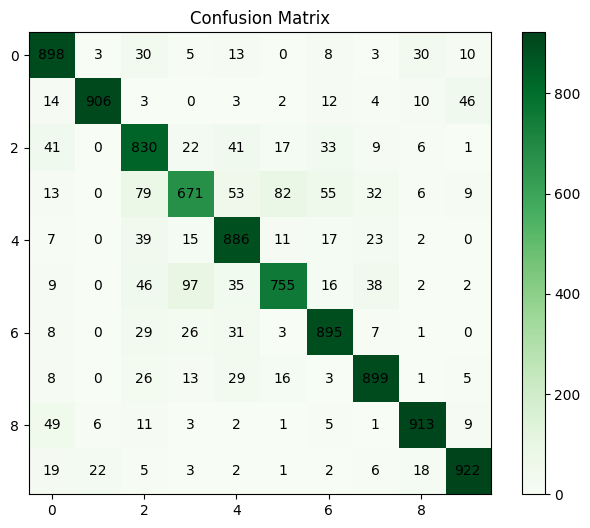

In [65]:
# TODO: Class Names...?

# Making predictions
predictions = model.predict(x_test)

# Creating a Confussion matrix
cm = confusion_matrix(
    np.argmax(y_test, axis=1),
    np.argmax(predictions, axis=1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Greens')
plt.title('Confusion Matrix')
plt.colorbar()

# Add numbers to the confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.show()